In [1]:
import networkx as nx
import numpy as np

In [2]:
G = nx.Graph()

#Hex codes for colors if we draw graph
blue, orange, green = "#1f77b4", "#ff7f0e","#2ca02c"

G.add_nodes_from([(1, {"color": blue}),
                  (2, {"color": orange}),
                  (3, {"color": blue}),
                  (4, {"color": green})])

G.add_edges_from([(1, 2),(2, 3),(1, 3),(3, 4)])
A = np.asarray(nx.adjacency_matrix(G).todense())
print(A)

[[0 1 1 0]
 [1 0 1 0]
 [1 1 0 1]
 [0 0 1 0]]


/var/folders/6s/fk_m3xbj6k99p2ch5cby1chr0000gn/T/ipykernel_59450/3108053774.py:12: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = np.asarray(nx.adjacency_matrix(G).todense())


In [3]:
def build_graph_color_label_representation(G,mapping_dict):
    one_hot_idxs = np.array([mapping_dict[v] for v in 
                             nx.get_node_attributes(G, 'color').values()])
    one_hot_encoding = np.zeros((one_hot_idxs.size,len(mapping_dict)))
    one_hot_encoding[np.arange(one_hot_idxs.size),one_hot_idxs] = 1
    return one_hot_encoding

X = build_graph_color_label_representation(G, {green: 0, blue: 1, orange: 2})
print(X)

[[0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]]


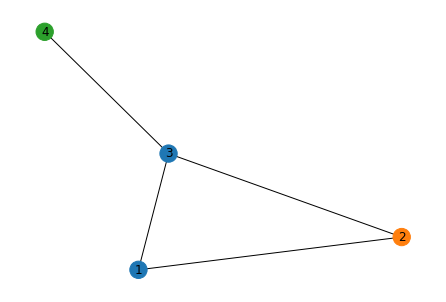

In [4]:
color_map = nx.get_node_attributes(G, 'color').values()
nx.draw(G, with_labels=True, node_color=color_map)

In [5]:
f_in, f_out = X.shape[1], 6
W_1 = np.random.rand(f_in, f_out) 
W_2 = np.random.rand(f_in, f_out) 
h = np.dot(X,W_1) + np.dot(np.dot(A, X), W_2)

In [6]:
import networkx as nx
import torch
from torch.nn.parameter import Parameter
import numpy as np
import torch.nn.functional as F

/Users/edvard/.local/share/virtualenvs/pyml-ZGva7g9H/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
class NodeNetwork(torch.nn.Module):

    def __init__(self, input_features):
        super().__init__()
        
        self.conv_1 = BasicGraphConvolutionLayer(input_features, 32)
        self.conv_2 = BasicGraphConvolutionLayer(32, 32)
        self.fc_1 = torch.nn.Linear(32, 16)
        self.out_layer = torch.nn.Linear(16, 2)
    
    def forward(self, X, A,batch_mat):
        x = self.conv_1(X, A).clamp(0)
        x = self.conv_2(x, A).clamp(0)
        output = global_sum_pool(x, batch_mat)
        output = self.fc_1(output)
        output = self.out_layer(output)
        return F.softmax(output, dim=1)

In [8]:
class BasicGraphConvolutionLayer(torch.nn.Module):

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        
        self.W2 = Parameter(torch.rand(
             (in_channels, out_channels), dtype=torch.float32))
        self.W1 = Parameter(torch.rand(
             (in_channels, out_channels), dtype=torch.float32))
         
        self.bias = Parameter(torch.zeros(
                 out_channels, dtype=torch.float32))
    
    def forward(self, X, A):
        potential_msgs = torch.mm(X, self.W2)
        propagated_msgs = torch.mm(A, potential_msgs)
        root_update = torch.mm(X, self.W1)
        output = propagated_msgs + root_update + self.bias
        return output

In [9]:
print('X.shape:', X.shape)

X.shape: (4, 3)


In [10]:
print('A.shape:', A.shape)

A.shape: (4, 4)


In [11]:
basiclayer = BasicGraphConvolutionLayer(3, 8)

In [12]:
out = basiclayer(X=torch.tensor(X, dtype=torch.float32),A=torch.tensor(A, dtype=torch.float32))

In [13]:
print('Output shape:', out.shape)

Output shape: torch.Size([4, 8])


In [14]:
out

tensor([[1.4607, 2.3568, 0.8547, 2.4495, 1.2775, 2.5050, 1.1815, 1.0993],
        [0.6946, 1.3657, 0.6860, 2.2339, 1.9166, 1.3998, 1.9002, 2.5383],
        [2.0485, 3.1002, 1.5595, 2.5878, 1.5957, 3.0359, 1.7090, 1.5298],
        [0.4018, 1.2457, 0.9284, 1.6350, 1.2893, 1.4469, 0.9527, 1.1745]],
       grad_fn=<AddBackward0>)

In [15]:
def global_sum_pool(X, batch_mat):
    if batch_mat is None or batch_mat.dim() == 1:
        return torch.sum(X, dim=0).unsqueeze(0)
    else:
        return torch.mm(batch_mat, X)

In [16]:
def get_batch_tensor(graph_sizes):
    starts = [sum(graph_sizes[:idx]) for idx in range(len(graph_sizes))]
    stops = [starts[idx]+graph_sizes[idx] for idx in range(len(graph_sizes))]
    tot_len = sum(graph_sizes)
    batch_size = len(graph_sizes)
    batch_mat = torch.zeros([batch_size, tot_len]).float()
    for idx, starts_and_stops in enumerate(zip(starts, stops)):
        start = starts_and_stops[0]
        stop = starts_and_stops[1]
        batch_mat[idx, start:stop] = 1
    return batch_mat

In [17]:
def collate_graphs(batch):
    adj_mats = [graph['A'] for graph in batch]
    sizes = [A.size(0) for A in adj_mats]
    tot_size = sum(sizes)
    # create batch matrix
    batch_mat = get_batch_tensor(sizes)
    # combine feature matrices
    feat_mats = torch.cat([graph['X'] for graph in batch],dim=0)
    # combine labels
    labels = torch.cat([graph['y'] for graph in batch], dim=0)
    # combine adjacency matrices
    batch_adj = torch.zeros([tot_size, tot_size], dtype=torch.float32)
    accum = 0
    for adj in adj_mats:
        g_size = adj.shape[0]
        batch_adj[accum:accum+g_size, accum:accum+g_size] = adj
        accum = accum + g_size
    repr_and_label = {
            'A': batch_adj, 
            'X': feat_mats,
            'y': labels,
            'batch' : batch_mat}

    return repr_and_label

In [18]:
def get_graph_dict(G, mapping_dict):
    # build dictionary representation of graph G
    A = torch.from_numpy(np.asarray(nx.adjacency_matrix(G).todense())).float()
    # build_graph_color_label_representation() was introduced with the first example graph
    X = torch.from_numpy(build_graph_color_label_representation(G,mapping_dict)).float()
    # kludge since there is not specific task for this example
    y = torch.tensor([[1, 0]]).float()
    return {'A': A, 'X': X, 'y': y, 'batch': None}

In [19]:
blue, orange, green = "#1f77b4", "#ff7f0e","#2ca02c"
mapping_dict = {green: 0, blue: 1, orange: 2}

G1 = nx.Graph()
G1.add_nodes_from([(1, {"color": blue}),
                   (2, {"color": orange}),
                   (3, {"color": blue}),
                   (4, {"color": green})])
G1.add_edges_from([(1, 2), (2, 3),(1, 3), (3, 4)])
G2 = nx.Graph()
G2.add_nodes_from([(1, {"color": green}),
                   (2, {"color": green}),
                   (3, {"color": orange}),
                   (4, {"color": orange}),
                   (5,{"color": blue})])
G2.add_edges_from([(2, 3),(3, 4),(3, 1),(5, 1)])
G3 = nx.Graph()
G3.add_nodes_from([(1, {"color": orange}),
                   (2, {"color": orange}),
                   (3, {"color": green}),
                   (4, {"color": green}),
                   (5, {"color": blue}),
                   (6, {"color":orange})])
G3.add_edges_from([(2, 3), (3, 4), (3, 1), (5, 1), (2, 5), (6, 1)])
G4 = nx.Graph()
G4.add_nodes_from([(1, {"color": blue}), (2, {"color": blue}), (3, {"color": green})])
G4.add_edges_from([(1, 2), (2, 3)])
graph_list = [get_graph_dict(graph,mapping_dict) for graph in [G1, G2, G3, G4]]


/var/folders/6s/fk_m3xbj6k99p2ch5cby1chr0000gn/T/ipykernel_59450/2350266009.py:3: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = torch.from_numpy(np.asarray(nx.adjacency_matrix(G).todense())).float()


In [20]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader


class ExampleDataset(Dataset):
    
    # Simple PyTorch dataset that will use our list of graphs
    def __init__(self, graph_list):
        self.graphs = graph_list
        
    def __len__(self):
        return len(self.graphs)
    
    def __getitem__(self,idx):
        mol_rep = self.graphs[idx]
        return mol_rep

In [21]:
dset = ExampleDataset(graph_list)
# Note how we use our custom collate function
loader = DataLoader(dset, batch_size=2, shuffle=False, collate_fn=collate_graphs)

In [22]:
torch.manual_seed(123)
node_features = 3
net = NodeNetwork(node_features)

In [23]:
batch_results = []

for b in loader:
    batch_results.append(net(b['X'], b['A'], b['batch']).detach())

G1_rep = dset[1]
G1_single = net(G1_rep['X'], G1_rep['A'], G1_rep['batch']).detach()

G1_batch = batch_results[0][1]
torch.all(torch.isclose(G1_single, G1_batch))

tensor(True)